## CV06 - Object Detection

1-stage detector를 미리 학습시킨 라이브러리 사용, RetinaNet

mkdir -p ~/aiffel/object_detection/data   
cd ~/aiffel/object_detection   
git clone https://github.com/fizyr/keras-retinanet.git   
cd keras-retinanet && python setup.py build_ext --inplace   
pip install -r requirements.txt   
pip install .

### 자율주행 보조장치, KITTI 데이터셋

자율주행을 위한 데이터셋, 2D object detection 뿐만 아니라 3D object detection 라벨 등 제공  
http://www.cvlibs.net/datasets/kitti/

In [1]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

import tensorflow_datasets as tfds

import copy
import cv2
from PIL import Image, ImageDraw

In [2]:
# 다운로드에 매우 긴 시간이 소요됩니다. *주의*
import urllib3
urllib3.disable_warnings()
(ds_train, ds_test), ds_info = tfds.load(
    'kitti',
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
)

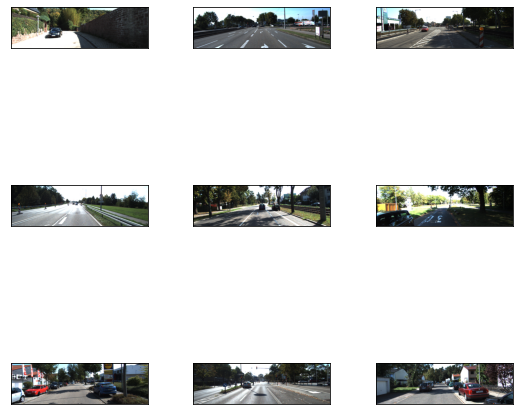

In [3]:
fig = tfds.show_examples(ds_train, ds_info)

In [4]:
ds_info
# 7481개의 훈련셋, 711개의 평가셋, 423개의 검증셋으로 구성
# 라벨: alpha, bbox, dimenstions, location, occluded, rotation_y, truncated 등

tfds.core.DatasetInfo(
    name='kitti',
    version=3.2.0,
    description='Kitti contains a suite of vision tasks built using an autonomous driving
platform. The full benchmark contains many tasks such as stereo, optical flow,
visual odometry, etc. This dataset contains the object detection dataset,
including the monocular images and bounding boxes. The dataset contains 7481
training images annotated with 3D bounding boxes. A full description of the
annotations can be found in the readme of the object development kit readme on
the Kitti homepage.',
    homepage='http://www.cvlibs.net/datasets/kitti/',
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'image/file_name': Text(shape=(), dtype=tf.string),
        'objects': Sequence({
            'alpha': tf.float32,
            'bbox': BBoxFeature(shape=(4,), dtype=tf.float32),
            'dimensions': Tensor(shape=(3,), dtype=tf.float32),
            'location': Tensor(shape=(3,), dtype

In [5]:
TakeDataset = ds_train.take(1)
# take(): 데이터셋을 하나씩 뽑을 수 있는 객체 생성

--Example--
['image', 'image/file_name', 'objects']
--objects--
{'alpha': <tf.Tensor: shape=(9,), dtype=float32, numpy=
array([-2.23, -1.94, -1.83, -1.73,  1.67,  1.72,  1.83, -1.6 ,  1.61],
      dtype=float32)>, 'bbox': <tf.Tensor: shape=(9, 4), dtype=float32, numpy=
array([[0.00266667, 0.5480837 , 0.45138666, 0.99424314],
       [0.05232   , 0.44434783, 0.45194668, 0.6428261 ],
       [0.20154667, 0.40148953, 0.45141333, 0.50722224],
       [0.28013334, 0.3547826 , 0.47261333, 0.42468598],
       [0.30032   , 0.17245571, 0.46949333, 0.22644928],
       [0.17824   , 0.09108695, 0.43077335, 0.18698873],
       [0.00266667, 0.        , 0.41154668, 0.14331724],
       [0.34952   , 0.32531402, 0.45301333, 0.3594525 ],
       [0.38501334, 0.22441223, 0.45896   , 0.2487037 ]], dtype=float32)>, 'dimensions': <tf.Tensor: shape=(9, 3), dtype=float32, numpy=
array([[1.47, 1.58, 3.55],
       [1.37, 1.7 , 4.38],
       [1.4 , 1.56, 3.91],
       [1.6 , 1.65, 3.77],
       [1.86, 1.63, 4.2 ],
  

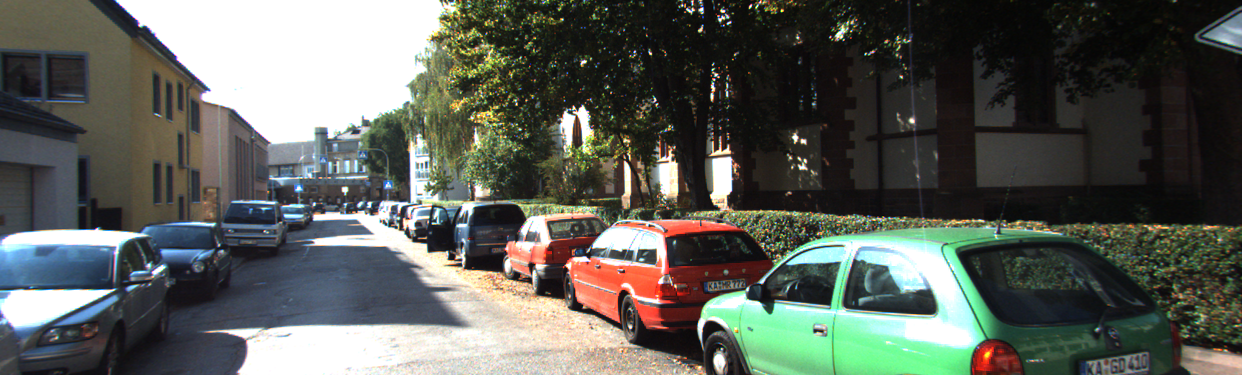

In [6]:
for example in TakeDataset:  
    print('--Example--')
    print(list(example.keys())) # example is `{'image': tf.Tensor, 'label': tf.Tensor}`
    image = example["image"]
    filename = example["image/file_name"].numpy().decode('utf-8')
    objects = example["objects"]

print('--objects--')
print(objects)
img = Image.fromarray(image.numpy())
img

[[ 680.72     374.      1234.85     205.73   ]
 [ 551.88     355.38     798.39     205.51999]
 [ 498.65     299.41998  629.97003  205.72   ]
 [ 440.64     269.95     527.46     197.77   ]
 [ 214.19     262.38     281.25     198.94   ]
 [ 113.13     308.16     232.24     213.45999]
 [   0.       374.       178.00002  220.67   ]
 [ 404.04     243.93001  446.44     205.12   ]
 [ 278.72     230.62     308.89     202.89   ]]
[ 680.72  374.   1234.85  205.73]
<PIL.Image.Image image mode=RGB size=1242x375 at 0x7F930067F210>


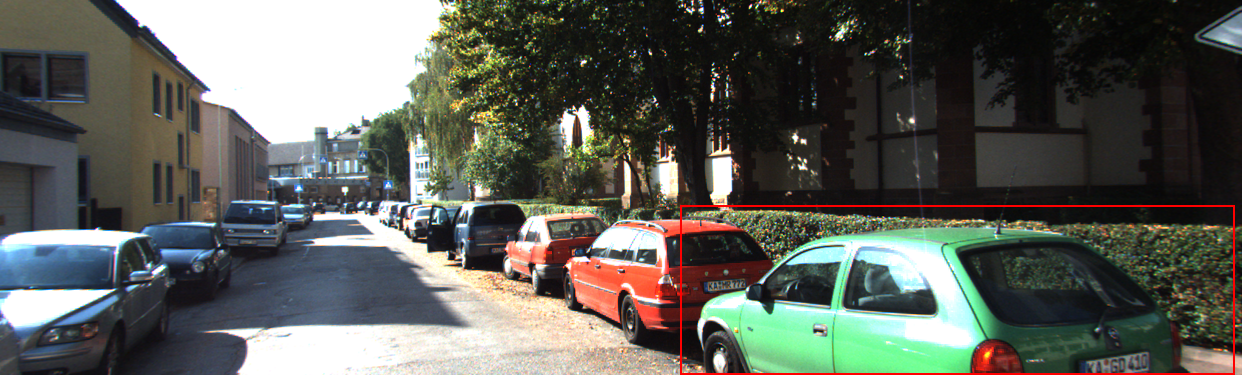

In [7]:
# 이미지 위에 바운딩 박스를 그려 화면에 표시해 주세요.
# bbox - 2D bounding box of object in the image (0-based index):
#                     contains left, top, right, bottom pixel coordinates
def visualize_bbox(input_image, object_bbox):
    input_image = copy.deepcopy(input_image)
    draw = ImageDraw.Draw(input_image)

    # 바운딩 박스 좌표(x_min, x_max, y_min, y_max) 구하기
    width, height = img.size
    x_min = object_bbox[:, 1] * width
    x_max = object_bbox[:, 3] * width
    y_min = height - object_bbox[:, 0] * height
    y_max = height - object_bbox[:, 2] * height
    
    # 바운딩 박스 그리기
    rects = np.stack([x_min, y_min, x_max, y_max], axis=1)
    print(rects)
    for _rect in rects:
        print(_rect)
        draw.rectangle(_rect, outline='red', width=2)
        print(input_image)
        return input_image

visualize_bbox(img, objects['bbox'].numpy())

### RetinaNet

Focal Loss for Dense Object Detection  
https://arxiv.org/abs/1708.02002  
kimcando94님의 Object Detection에 대하여_01: Overall Object detection flow  
https://kimcando94.tistory.com/115  
김홍배님의 Focal loss의 응용(Detection & Classification)  
https://www.slideshare.net/ssuser06e0c5/focal-loss-detection-classification  

1-stage detector모델인 YOLO, SSD는 2-stage detector인 Faster-RCNN 보다  
속도는 빠르지만 성능이 낮다  
이를 해결하기 위해 focal loss와 FPN(Feature Pyramid Network)를 적용한 RetinaNet이 나옴  

일반적으로 이미지는 물체보다 배경을 더 많이 학습하게 된다.  
이를 개선하기 위해 loss를 바꿨다.
focal loss는 교차 엔트로피를 기반으로 만들어졌다.  
교차 엔트로피는 ground truth class에 대한 확률이 높으면 잘 분류된 것으로 판단하여  
손실이 줄어든다.
모델에서는 배경 class가 많아지지 않도록 람다를 높여서 조절한다.

FPN(Feature Pyramid Network): 특성을 피라미드처럼 쌓아서 사용하는 방식  
레이어가 깊어질수록 한 셀은 넓은 범위의 정보를 가지게 된다.  
SSD는 각 레이어의 다양한 크기의 특성 맵에서 결과를 얻는 방식이라면  
RetinaNet은 뒷쪽의 특성 맵과 앞쪽의 특성 맵을 합쳐서 사용, 넓은 면과 좁은 면을 같이 사용  
https://aiffelstaticprd.blob.core.windows.net/media/images/GC-3-P-FPN.max-800x600.png

### Keras RetinaNet

https://github.com/fizyr/keras-retinanet  
케라스 라이브러리로 구현된 RetinaNet

tensorflow_dataset그대로 이용하려면 라이브러리 수정,  
하지만 데이터셋 포맷을 csv형태로 변경해 줄 수 있다.  
API를 이용하여 이미지와 각 이미지의 바운딩 박스 라벨 정보 얻을 수 있음,  
이를 csv형태로 한 줄씩 저장
#### 클래스 및 바운딩 박스 정보 추출

In [8]:
ds_train

<_OptionsDataset shapes: {image: (None, None, 3), image/file_name: (), objects: {alpha: (None,), bbox: (None, 4), dimensions: (None, 3), location: (None, 3), occluded: (None,), rotation_y: (None,), truncated: (None,), type: (None,)}}, types: {image: tf.uint8, image/file_name: tf.string, objects: {alpha: tf.float32, bbox: tf.float32, dimensions: tf.float32, location: tf.float32, occluded: tf.int64, rotation_y: tf.float32, truncated: tf.float32, type: tf.int64}}>

In [9]:
import os
data_dir = os.getenv('HOME')+'/aiffel/object_detection/data'
img_dir = os.getenv('HOME')+'/kitti_images'
train_csv_path = data_dir + '/kitti_train.csv'

# parse_dataset 함수를 구현해 주세요.
def parse_dataset(dataset, img_dir="kitti_images", total=0):
    if not os.path.exists(img_dir):
        os.mkdir(img_dir)

    type_class_map = {
        0: "car",
        1: "car",
        2: "car",
        3: "person",
        4: "person",
        5: "person",
    }

    df = pd.DataFrame(columns=["img_path", "x1", "y1", "x2", "y2", "class_name"])
    for item in tqdm(dataset, total=total):
        filename = item['image/file_name'].numpy().decode('utf-8')
        img_path = os.path.join(img_dir, filename)
        img = Image.fromarray(item['image'].numpy())
        img.save(img_path)
        object_bbox=item['objects']['bbox']
        object_type=item['objects']['type'].numpy()
        width, height = img.size
        
        
        # tf.dataset의 bbox좌표가 0과 1사이로 normalize된 좌표이므로 이를 pixel좌표로 변환합니다.
        x_min = object_bbox[:,1] * width
        x_max = object_bbox[:,3] * width
        y_min = height - object_bbox[:,2] * height
        y_max = height - object_bbox[:,0] * height

        # 한 이미지에 있는 여러 Object들을 한 줄씩 pandas.DataFrame에 append합니다.
        rects = np.stack([x_min, y_min, x_max, y_max], axis=1).astype(np.int)
        for i, _rect in enumerate(rects):
            _type = object_type[i]
            if _type not in type_class_map.keys():
                continue
            df = df.append({
                "img_path": img_path,
                "x1": _rect[0],
                "y1": _rect[1],
                "x2": _rect[2],
                "y2": _rect[3],
                "class_name": type_class_map[_type]
            }, ignore_index=True)
            break
            
    return df

df_train = parse_dataset(ds_train, img_dir, total=ds_info.splits['train'].num_examples)
df_train.to_csv(train_csv_path, sep=',',index = False, header=False)

100%|██████████| 6347/6347 [10:14<00:00, 10.32it/s]


In [10]:
test_csv_path = data_dir + '/kitti_test.csv'

df_test = parse_dataset(ds_test, img_dir, total=ds_info.splits['test'].num_examples)
df_test.to_csv(test_csv_path, sep=',',index = False, header=False)

100%|██████████| 711/711 [01:11<00:00,  9.88it/s]


#### 클래스 맵핑
데이터셋엔 클래스가 string이지만 모델이 파악하려면 숫자로 바꿔 알려줘야 한다.  
각 클래스가 어떤 인덱스로 맵핑될지 미리 정하고 이후 추론된 숫자 인덱스로 클래스 이름을 알 수 있다.

In [11]:
class_txt_path = data_dir + '/classes.txt'

def save_class_format(path="./classes.txt"):
    class_type_map = {
        'car':0,
        'person':1
    }
    with open(path, mode='w', encoding='utf-8') as f:
        for k, v in class_type_map.items():
            f.write(f'{k},{v}\n')

save_class_format(class_txt_path)

In [13]:
# RetinaNet 훈련이 시작됩니다!! 50epoch 훈련에 1시간 이상 소요될 수 있습니다. 
# batch_size나 worker, epoch 조절 gpu_out-of-memory 에러 발생시
!python ~/aiffel/object_detection/keras-retinanet/keras_retinanet/bin/train.py --gpu 0 --multiprocessing --workers 4 --batch-size 2 --epochs 50 --steps 195 csv ~/aiffel/object_detection/data/kitti_train.csv ~/aiffel/object_detection/data/classes.txt

2020-10-27 09:34:55.601936: W tensorflow/stream_executor/platform/default/dso_loader.cc:59] Could not load dynamic library 'libcudart.so.10.1'; dlerror: libcudart.so.10.1: cannot open shared object file: No such file or directory
2020-10-27 09:34:55.601986: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2020-10-27 09:34:56.909165: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcuda.so.1
2020-10-27 09:34:56.938581: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:982] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2020-10-27 09:34:56.939023: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1716] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: GeForce RTX 2070 computeCapability: 7.5
coreClock: 1.455GHz coreCount: 36 deviceMemorySize: 7.79GiB devi

Epoch 1/50
195/195 [==============================] - ETA: 0s - loss: 3.4531 - regression_loss: 2.6369 - classification_loss: 0.8162
Epoch 00001: saving model to ./snapshots/resnet50_csv_01.h5
195/195 [==============================] - 682s 3s/step - loss: 3.4531 - regression_loss: 2.6369 - classification_loss: 0.8162
Epoch 2/50
  1/195 [..............................] - ETA: 0s - loss: 2.9528 - regression_loss: 2.3070 - classification_loss: 0.6458

In [26]:
!python ~/aiffel/object_detection/keras-retinanet/keras_retinanet/bin/convert_model.py ./snapshots/resnet50_csv_50.h5 ./snapshots/resnet50_csv_50_infer.h5

Traceback (most recent call last):
  File "/home/aiffel0042/aiffel/object_detection/keras-retinanet/keras_retinanet/bin/convert_model.py", line 31, in <module>
    from ..utils.config import read_config_file, parse_anchor_parameters, parse_pyramid_levels
  File "/home/aiffel0042/aiffel/object_detection/keras-retinanet/keras_retinanet/bin/../../keras_retinanet/utils/config.py", line 19, in <module>
    from tensorflow import keras
ModuleNotFoundError: No module named 'tensorflow'


### 시각화

In [3]:
# 변환한 모델을 load한 후 추론 및 시각화 하기
# 일정 점수 이하인 경우는 제거해야 한다.

#$ mkdir -p ~/aiffel/object_detection/test_set
#$ wget https://aiffelstaticprd.blob.core.windows.net/media/documents/test_set.zip
#$ mv test_set.zip ~/aiffel/object_detection/test_set
#$ cd ~/aiffel/object_detection/test_set && unzip test_set.zip

%matplotlib inline

# automatically reload modules when they have changed
%load_ext autoreload
%autoreload 2

# import keras
import keras

# import keras_retinanet
from keras_retinanet import models
from keras_retinanet.models import load_model
from keras_retinanet.utils.image import read_image_bgr, preprocess_image, resize_image
from keras_retinanet.utils.visualization import draw_box, draw_caption
from keras_retinanet.utils.colors import label_color
from keras_retinanet.utils.gpu import setup_gpu

# import miscellaneous modules
import matplotlib.pyplot as plt
import cv2
import os
import numpy as np
import time

gpu = '0'
setup_gpu(gpu)

dir_path = os.getenv('HOME') + '/aiffel/object_detection/keras-retinanet'
model_path = os.path.join(dir_path, 'snapshots', 'resnet50_csv_50_infer.h5')
model = load_model(model_path, backbone_name='resnet50')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
1 Physical GPUs, 1 Logical GPUs


[593.3969  175.17348 625.36304 206.38805]
[195.35567 129.16762 357.99146 236.69008]


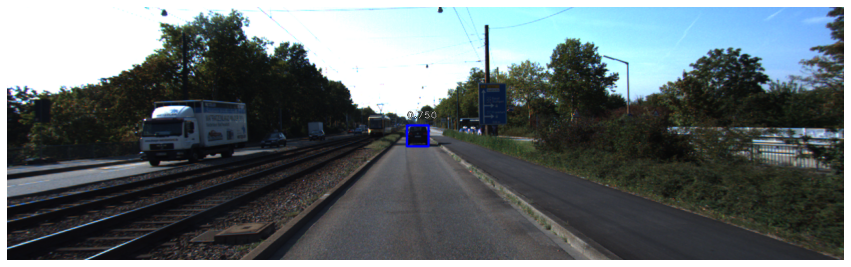

In [4]:
import os
img_path = os.getenv('HOME')+'/aiffel/object_detection/test_set/go_1.png'

# inference_on_image 함수를 구현해 주세요.
def inference_on_image(model, img_path="./test_set/go_0.png", visualize=True):
    image = read_image_bgr(img_path)

    # copy to draw on
    draw = image.copy()
    draw = cv2.cvtColor(draw, cv2.COLOR_BGR2RGB)

    color_map = {
        0: (0, 0, 255), # blue
        1: (255, 0, 0) # red
    }

    # preprocess image for network
    image = preprocess_image(image)
    image, scale = resize_image(image)

    # process image
    boxes, scores, labels = model.predict_on_batch(np.expand_dims(image, axis=0))

    # correct for image scale
    boxes /= scale

    # display images
    if  visualize:
        for box, score, label in zip(boxes[0], scores[0], labels[0]):
            print(box)
            if score < 0.5:
                break
            b = box.astype(int)
            draw_box(draw, b, color=color_map[label])

            caption = "{:.3f}".format(score)
            draw_caption(draw, b, caption)

        plt.figure(figsize=(15, 15))
        plt.axis('off')
        plt.imshow(draw)
        plt.show() 

inference_on_image(model, img_path=img_path)

[770.6509  146.75868 844.55444 317.208  ]
[761.52014 150.19055 858.50696 315.19403]


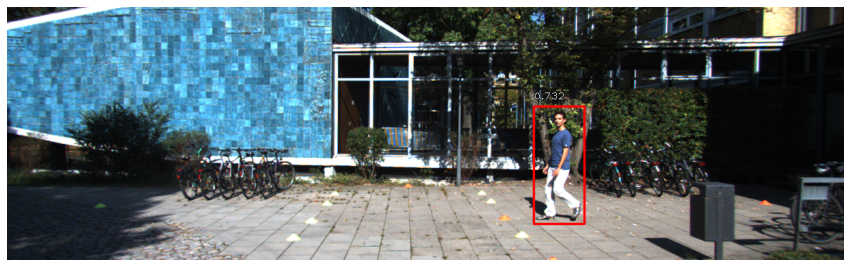

In [5]:
img_path = os.getenv('HOME')+'/aiffel/object_detection/test_set/stop_1.png'
inference_on_image(model, img_path=img_path)